## Utility functions for Droplet MD Simulation Post-Processing

The following Notebook contains all functions for making use of the MD simulation trajectory files in PDB Format to obtain spatial density profile which is used to obtain the droplet diameter and droplet contact angle. The key parameters that need to specified in the cells that follows are : **N_molecules, N_timesteps, xlim, ylim, zlim and the filename passed to get_txt function which converts a PDB file to txt format**. 

In the computation of density, the user may choose to specify any other cell_size. dx and dz determine the grid spacing in the X and Z directions on which the computation is made approximating each dx.dz sized box as a cuboid.

As long as the standard PDB format file is used, none of the functions may be changed internally.

*Note - The drop is assumed to be resting on a substrate on the X-Y plane and the Z direction is normal to the substrate. This code was used for a water droplet.*

In [22]:
import IO_Lib as io
import density_Lib as rhofns
import fit_ellipse
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import minimize


In [23]:
@jit
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [24]:
@jit
def cart_to_cyl(xc,yc,zc):
    x_m = xc - np.mean(xc)
    y_m = yc - np.mean(yc)
    z_cyl = zc - min(zc)
    r_cyl = np.sqrt(x_m**2 + y_m**2)
    M = x_m < 0
    theta_cyl = M*np.pi + np.arctan(y_m/x_m)
    return r_cyl,z_cyl,theta_cyl

In [25]:
@jit
def get_neighbors(x,y,x_slice,y_slice,p):
    N = x_slice[(x_slice < x+p) & (x_slice > x-p) & (y_slice < y+p) & (y_slice > y-p)] 
    return N.size

In [26]:
@jit
def get_interface(r,z,theta,z_curr):
    M = np.logical_and(z < z_curr + 2.5, z > z_curr - 2.5)
    r_slice = r[M]
    theta_slice = theta[M]
    x_slice = r_slice*np.cos(theta_slice)
    y_slice = r_slice*np.sin(theta_slice)

    xi = np.linspace(min(x_slice),max(x_slice),int((max(x_slice)-min(x_slice))/0.5))
    yi = np.linspace(min(y_slice),max(y_slice),int((max(y_slice)-min(y_slice))/0.5))
    N_mid = get_neighbors(0,0,x_slice,y_slice,4)
    xin = []
    yin = []
    for x in xi:
        for y in yi:
            N = get_neighbors(x,y,x_slice,y_slice,4)
            if N <= N_mid/2+0.5 and N >= N_mid/2-0.5:
                xin.append(x)
                yin.append(y)
    return np.asarray(xin),np.asarray(yin)

In [27]:
@jit
def R_theta_z(params,theta_val,z_val,zmax):
    c0 = 46
    a = params[0]
    c1 = params[1]
    c2 = params[2]
    z_normed = z_val/zmax
    z_comp = (c1*(z_val/c0)**2 + c2*(z_val/c0)-(c1+c2))
    if z_comp > 0:
        z_comp = np.sqrt(z_comp)
    theta_comp = np.sqrt(np.sin(theta_val)**2 + (a*np.cos(theta_val))**2)
    return theta_comp*z_comp

In [28]:
@jit
def target_function(params):
    error = 0
    dz = 2
    zmax = 30
    for i in range(0,int(zmax/dz)):
        z_curr = 5+i*dz
        xin,yin = get_interface(r,z,theta,z_curr)
        R = np.sqrt(np.square(xin) + np.square(yin))
        M = xin < 0
        theta_val = M*np.pi + np.arctan(yin/xin)
        R_pred = R_theta_z(params,theta_val,z_curr,zmax)
        error+= np.sum(np.square(R_pred-R))

    return error

In [29]:
N_molecules = 3375 #Number of molecules having atom : atomname
N_timesteps = 190 #Number of time steps for which N_molecules trajectory was stored
Xlim = [80,240] #Max Limits on X coord (Based on Box Dimensions)
Ylim = [80,240] #Max Limits on Y coord
Zlim = [0,55]  #Max Limits on Z coord

In [30]:
#Example : Generate txt file of coordinates of oxygen ('O') from pdb file with name 'e=0.5_E=0' 
#Delete the old file
io.gen_txt('./PDB/','15','76')

In [31]:
X,Y,Z = io.get_coordinates('15', N_molecules, N_timesteps)


In [32]:
x0,y0,z0 = io.get_clean_coord(X,Y,Z,180, Xlim, Ylim, Zlim)
r,z,theta = cart_to_cyl(x0,y0,z0)

In [33]:
M = z < Zlim[1]
z = z[M]
r = r[M]
theta = theta[M]

In [36]:
x0 = [1.1,-2000,2000]
N_minimize = 10 # Number of minimization steps (each having 5 BFGS steps)

In [37]:
for i in range(0,N_minimize):
    if i > 0:
        x0 = x_next.x
    x_next = minimize(target_function, x0, method='BFGS',options={'maxiter':5})
    print("Parameter Value:",x_next.x)
    print("Error Value:",x_next.fun)

Parameter Value: [ 1.01839664e+00 -2.19732336e+03  1.63610668e+03]
Error Value: 225440.0909734082
Parameter Value: [ 1.07157008e+00 -1.67655196e+03  1.03199860e+03]
Error Value: 212212.252627765
Parameter Value: [ 1.04855967e+00 -1.67756444e+03  9.83269676e+02]
Error Value: 211044.37995792023
Parameter Value: [ 1.05677218e+00 -1.64857279e+03  9.59763127e+02]
Error Value: 210853.35669274227
Parameter Value: [ 1.05153981e+00 -1.63727914e+03  9.34346823e+02]
Error Value: 210733.5788496714
Parameter Value: [ 1.05567700e+00 -1.62241414e+03  9.22270872e+02]
Error Value: 210662.6508796082
Parameter Value: [ 1.05207361e+00 -1.59581278e+03  8.78576600e+02]
Error Value: 210560.36329148672
Parameter Value: [ 1.05681413e+00 -1.58679961e+03  8.74939894e+02]
Error Value: 210525.22451577772
Parameter Value: [ 1.05550193e+00 -1.57719282e+03  8.58716594e+02]
Error Value: 210507.63709703708
Parameter Value: [ 1.05708352e+00 -1.57334599e+03  8.57116615e+02]
Error Value: 210501.09316127189


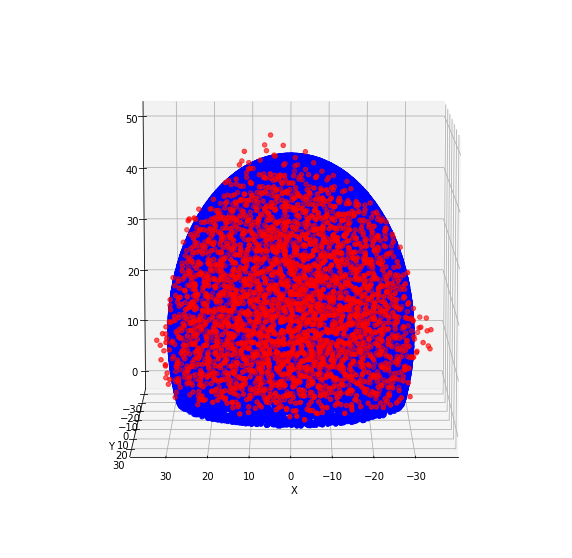

In [44]:
#Check how the fit looks
dz = 0.05
zmax = 46
params = x_next.x
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(0,int(zmax/dz)):
    z_curr = i*dz
    theta_val = 2*np.pi*np.random.rand(1,50)
    R_pred = R_theta_z(params,theta_val,z_curr,zmax)
    ax.scatter(R_pred*np.cos(theta_val),R_pred*np.sin(theta_val),z_curr,color='b')

ax.scatter(r*np.cos(theta),r*np.sin(theta),z,color='r')
ax.view_init(10, 90)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [39]:
theta_val = np.linspace(0,2*np.pi,50)
R_p = R_theta_z(params,theta_val,10,zmax)

In [40]:
M,m,xc,yc,phi = fit_ellipse.fit_ellipse(R_p*np.cos(theta_val),R_p*np.sin(theta_val))

In [41]:
print("Base Diameter:",2*M)

Base Diameter: 60.885593787472054


In [11]:
# dz = 1
# z_max = max(z)-2
# major_axes = []
# minor_axes = []
# xcenter = []
# ycenter = []
# for i in range(0,int(z_max/dz)):
#     z_curr = i*dz
#     xin,yin = get_interface(r,z,theta,z_curr)
#     M,m,xc,yc,phi = fit_ellipse.fit_ellipse(xin,yin)
#     major_axes.append(M)
#     minor_axes.append(m)
#     xcenter.append(xc)
#     ycenter.append(yc)

In [12]:
# t = np.linspace(-np.pi,np.pi,100)
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# for i in range(0,int(z_max/dz)):
#     ax.scatter(xcenter[i]+major_axes[i]*np.cos(t),ycenter[i]+minor_axes[i]*np.sin(t),i*dz*np.ones(np.shape(t)))

# ax.scatter(r*np.cos(theta),r*np.sin(theta),z)
# ax.view_init(20, 120)
# plt.show()